# **Design Space Exploration**
- Define the most suitable hardware architecture to implement StereoSpike network.
    - Leverage the use of Depthwise Separable (DWS) convolutions.
- The metrics chosen to explore the architectures are memory traffic and latency.

## *Libraries:*

In [1]:
from typing import List
from pprint import pprint

## *Functions:*

In [2]:
from analysis_utils.custom_func import ConvLayerSpec
from analysis_utils.custom_func import analyze_original_mem_traffic
from analysis_utils.custom_func import analyze_original_latency
from analysis_utils.custom_func import analyze_prop_mem_traffic
from analysis_utils.custom_func import plot_total_se_latency_surface
from analysis_utils.custom_func import analyze_se_latency

## *Network Information:*

In [3]:
# Stereospike DW Filter (R, S)
# All layers have the same DW filter size
filter_size = (7, 7)  

In [4]:
network_layers: List[ConvLayerSpec] = [
    ConvLayerSpec("stem", (4, 260, 346), (32, 260, 346)),
    ConvLayerSpec("conv1", (32, 260, 346), (64, 130, 173)),
    ConvLayerSpec("conv2", (64, 130, 173), (128, 65, 87)),
    ConvLayerSpec("conv3", (128, 65, 87), (256, 33, 44)),
    ConvLayerSpec("conv4", (256, 33, 44), (512, 17, 22)),
    ConvLayerSpec("bottleneck", (512, 17, 22), (512, 17, 22)),
    ConvLayerSpec("deconv4", (512, 17, 22), (256, 33, 44)),
    ConvLayerSpec("deconv3", (256, 33, 44), (128, 65, 87)),
    ConvLayerSpec("deconv2", (128, 65, 87), (64, 130, 173)),
    ConvLayerSpec("deconv1", (64, 130, 173), (32, 260, 346)),
    ConvLayerSpec("depth4", (256, 33, 44), (1, 260, 346)),
    ConvLayerSpec("depth3", (128, 65, 87), (1, 260, 346)),
    ConvLayerSpec("depth2", (64, 130, 173), (1, 260, 346)),
    ConvLayerSpec("depth1", (32, 260, 346), (1, 260, 346))]

## **1. Conventional Architectures**
Based on [1], three main hardware architectures have been proposed to implement DWS convolutions:
1. *Unified Engine* (UE): single processing element (PE) array for sequential execution.
2. *Separated Engine* (SE): dedicated PE arrays for parallel execution.
3. *Reconfigurable Engine* (RE): single PE array with dinamic partitioning for parallel execution.  

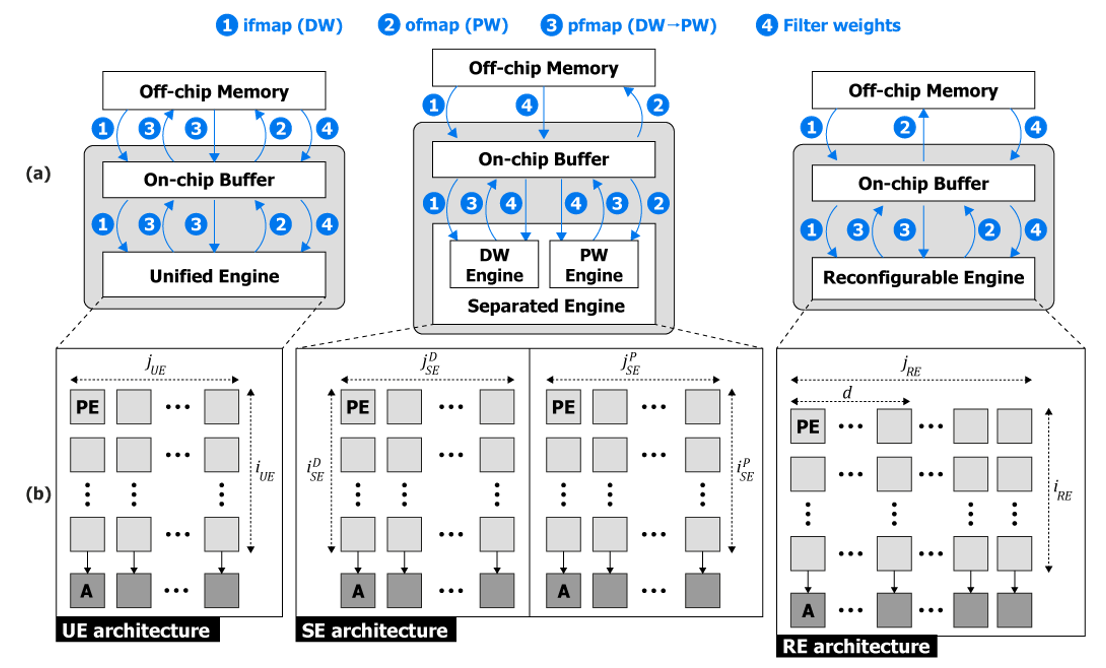

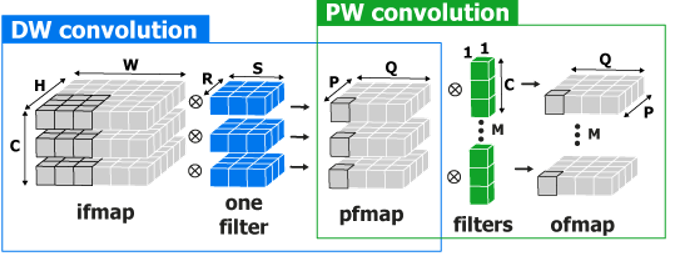

### **1.1 Memory Traffic**
- Data movement contributes significantly to a system's energy consumption [2] and its minimization is critical for energy-efficient designs.  
- Following the framework presented in [1] and extending the formulas to any tensor dimension.
    - Assumption: ideal data reuse scheme (engines only read/write memory once per data).

The size of the individual tensors are:  
- &#9312; ifmap (DW) --> $HWC$ (binary data)
- &#9313; ofmap (PW) --> $PQM$ (binary/multibit data)
- &#9314; pfmap (DW->PW) --> $PQC$ (multibit data)
- &#9315; weights --> $RSC + MC$ (multibit data)  

**Off-chip:**
- Assume that &#9313; is binary to represent the final ofmap after activation function.
1. *UE Architecture:*  
    - &#9312; and &#9313; are binary --> assuming final ofmaps.  
    - &#9314; and &#9315; are multibit.
$$
    A_{UE}^{off} = \underset{\text{read}}{\underbrace{1+3+4}} + \underset{\text{write}}{\underbrace{2+3}}
$$


2. *SE/RE Architecture:*
    - &#9312; and &#9313; are binary --> assuming final ofmaps.  
    - &#9315; are multibit.
$$
    A_{SE/RE}^{off} = \underset{\text{read}}{\underbrace{1+4}} + \underset{\text{write}}{\underbrace{2}}
$$

**On-chip:**
- Assume that &#9313; is multibit to represent the required accumulation before activation function.
    - Include 1 binary &#9313; for the result of activation function.
- All achitectures have the same traffic.
    - &#9312; and &#9313; (write) are binary.  
    - &#9313; (read), &#9314; and &#9315; are multibit.
$$
    A^{on} = \underset{\text{read}}{\underbrace{1+2+3+4}} + \underset{\text{write}}{\underbrace{2+3}}
$$

#### **1.1.1 Analysis**
The bitwidth of each tensor element determines the memory traffic with a fixed network.
- Assume 8-bit quantization for weights.

In [5]:
# Bitwidths for weights, pfmap, and ofmap
n_bits = (8, 16, 16)

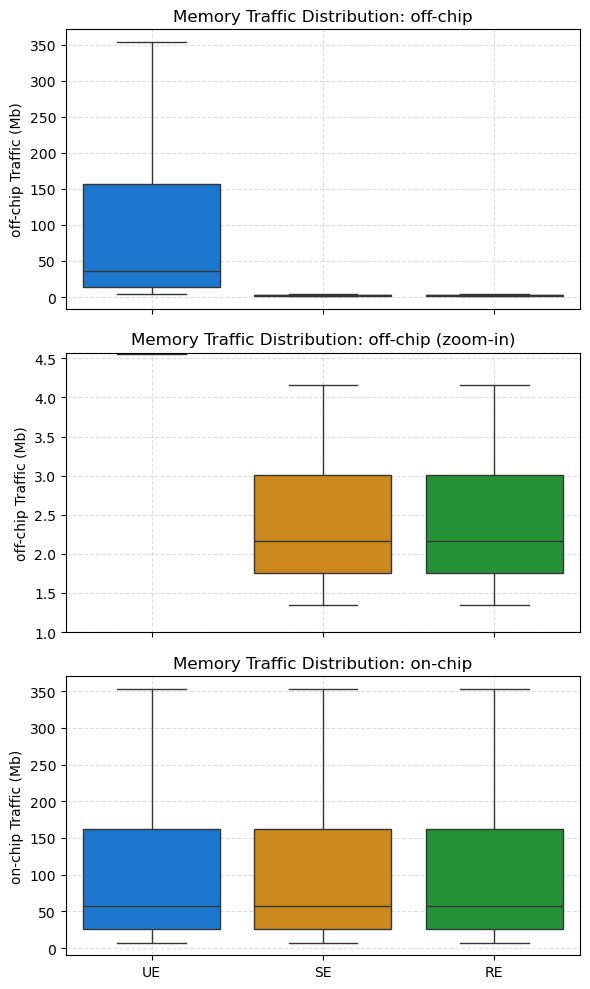

In [6]:
# Analyze memory traffic
traffic_result = analyze_original_mem_traffic(
    network_layers=network_layers,
    filter_size=filter_size,
    n_bit=n_bits
)

In [7]:
# Visualize numerical results
pprint(traffic_result)

[{'RE_off': 3.09100341796875,
  'RE_on': 57.99822998046875,
  'SE_off': 3.09100341796875,
  'SE_on': 57.99822998046875,
  'UE_off': 14.07244873046875,
  'UE_on': 57.99822998046875,
  'layer': 'stem'},
 {'RE_off': 4.1456298828125,
  'RE_on': 48.0714111328125,
  'SE_off': 4.1456298828125,
  'SE_on': 48.0714111328125,
  'UE_off': 26.1085205078125,
  'UE_on': 48.0714111328125,
  'layer': 'conv1'},
 {'RE_off': 2.1494140625,
  'RE_on': 24.2392578125,
  'SE_off': 2.1494140625,
  'SE_on': 24.2392578125,
  'UE_off': 13.1943359375,
  'UE_on': 24.2392578125,
  'layer': 'conv2'},
 {'RE_off': 1.3426513671875,
  'RE_on': 12.6864013671875,
  'SE_off': 1.3426513671875,
  'SE_on': 12.6864013671875,
  'UE_off': 7.0145263671875,
  'UE_on': 12.6864013671875,
  'layer': 'conv3'},
 {'RE_off': 1.6328125,
  'RE_on': 7.4765625,
  'SE_off': 1.6328125,
  'SE_on': 7.4765625,
  'UE_off': 4.5546875,
  'UE_on': 7.4765625,
  'layer': 'conv4'},
 {'RE_off': 2.556640625,
  'RE_on': 11.322265625,
  'SE_off': 2.556640625,

- Due to the significant off-chip traffic in UE architecture, **only SE and RE architectures** should be consider for the StereoSpike network.

### **1.2 Latency**
- To leverage the high temporal resolution in event cameras [3], low-latency processing is a crucial factor.  
- Following the framework presented in [1] and extending the formulas to any tensor dimension: input, output, filter, and stride.
    - Assumption 1: multiplication takes 1 cycle.
    - Assumption 2: ideal memory model (no memory access delay).

**UE Architecture:**
- Add latencies from DW and PW stages.
$$
t_{UE} = t_{DW} + t_{PW} \\
\qquad \qquad \qquad \qquad \qquad \qquad \qquad = \left\lceil \frac{RS}{i_{UE}} \right\rceil PQ \left\lceil \frac{C}{j_{UE}} \right\rceil + \left\lceil \frac{C}{i_{UE}} \right\rceil PQ \left\lceil \frac{M}{j_{UE}} \right\rceil
$$

**SE Architecture:**
- Consider only the stage that takes longer to process.
    - PW stage since output tensor volumen is always higher in a U-Net.
$$
t_{SE} = max(t_{DW},t_{PW}) \\
\qquad = \left\lceil \frac{C}{i^{P}_{SE}} \right\rceil PQ \left\lceil \frac{M}{j^{P}_{SE}} \right\rceil
$$

**RE Architecture:**  
- Two operation modes need to be considered:
$$
\text{operation}=
    \begin{cases}
        \text{inter-channel}, &  QC + CM \leq PQC + Cj_{RE} \\
        \text{intra-channel}, & \text{otherwise} 
    \end{cases}
$$

1. *Inter-channel*: for smaller input and fewer PW filters.
    - It generates 1 ofmap row with all its channels.
    - Two pipelines based on the number of output channels that can be computed concurrently: DW-PW or PW-DW.
$$
t_{RE}=
    \begin{cases}
        PQR \left\lceil \frac{C}{d} \right\rceil, &  M \leq j_{RE} - d \\
        \left\lceil \frac{C}{i_{RE}} \right\rceil PQ \left\lceil \frac{M}{j_{RE} - d} \right\rceil, & \text{otherwise} 
    \end{cases}
$$

2. *Intra-channel*: for larger input and many PW filters. 
    - It generates all the rows of several ofmap channels.
    - It has 2 stages:
        - Stage 1: All DW and some PW computations.
        - Stage 2: Remaining PW computations.
$$
\begin{split}
t_{RE} & = t_{s1} + t_{s2} \\
& = PQR \left\lceil \frac{C}{d} \right\rceil + PQ \left\lceil \frac{C}{i_{RE}} \right\rceil \left\lceil \frac{M - \left\lfloor \frac{R\left\lceil \frac{C}{d} \right\rceil}{\left\lceil \frac{C}{j_{RE} - d} \right\rceil} \right\rfloor}{j_{RE}} \right\rceil 
\end{split}
$$


#### **1.2.1 Analysis**
The number of rows and columns $(i,j)$ determines the latency with a fixed network.
- Assume accumulation in the vertical direction.
- Considering 3 cases based on the number of input/output channels: multiples of 32.
    - RE architecture is designed to handle varying number of input/output channels.

##### **1.2.1.1 Case 1**
- Input channels < Output channels.
- Resemble *encoder* conditions.

**UE:**
- For DW convolution: (49,64)
- For PW convolution: (64,128)
- Therefore, we use: *(49,128)*
    - DW convolution can handle 64 input channels with all the filter rows.
    - PW convolution can produce 128 output channels.

**SE:** 
- For DW convolution: (49,64)
- For PW convolution: (64,128)
    - DW convolution can handle 64 input channels with all the filter rows.
    - PW convolution can produce 128 output channels.

**RE:**
- For DW convolution: (7,64)
    - Its dataflow only considers the access to a single row with all their channels and perform an incomplete slididing window in several cycles. 
- For PW convolution: (64,128)  
- Therefore, we use: *(64,128)*
    - DW convolution can handle up to 128 input channels with a single filter row per cycle (idle PEs).
    - PW convolution can handle up to 64 input channels and produce 128 output channels.  
    
- *Inter-channel* --> small number of input/output channels
    - Choose a balance approach with 64 columns for each stage: handle 64 input channels and generate 64 output channels.
    - We use *d = 64*
    - In the case of prediction layers with only 1 output channel, we use optimize to *d = 127*  

- *Intra-channel* --> large number of input/output channels
    - Dynamic assignment of columns for both convolutions --> 2 stages.
    - During stage 1, most of the computations are focused on finishing DW convolutions
        - We use *d = 120*
    - Stage 2 automatically will take all 128 columns to complete PW convolutions. 

In [8]:
# (row, column) --> (i,j)

# UE
ue_array = (49, 128)

# SE
se_array_dw = (49, 64)
se_array_pw = (64, 128)

# RE
re_array = (64, 128)
dw_cols_inter = 64  # Number of columns for DW in RE for inter-channel
dw_cols_inter_prediction = 127  # Number of columns for DW in RE for inter-channel operation in prediction layers
dw_cols_intra = 120  # Number of columns for DW in RE for intra-channel

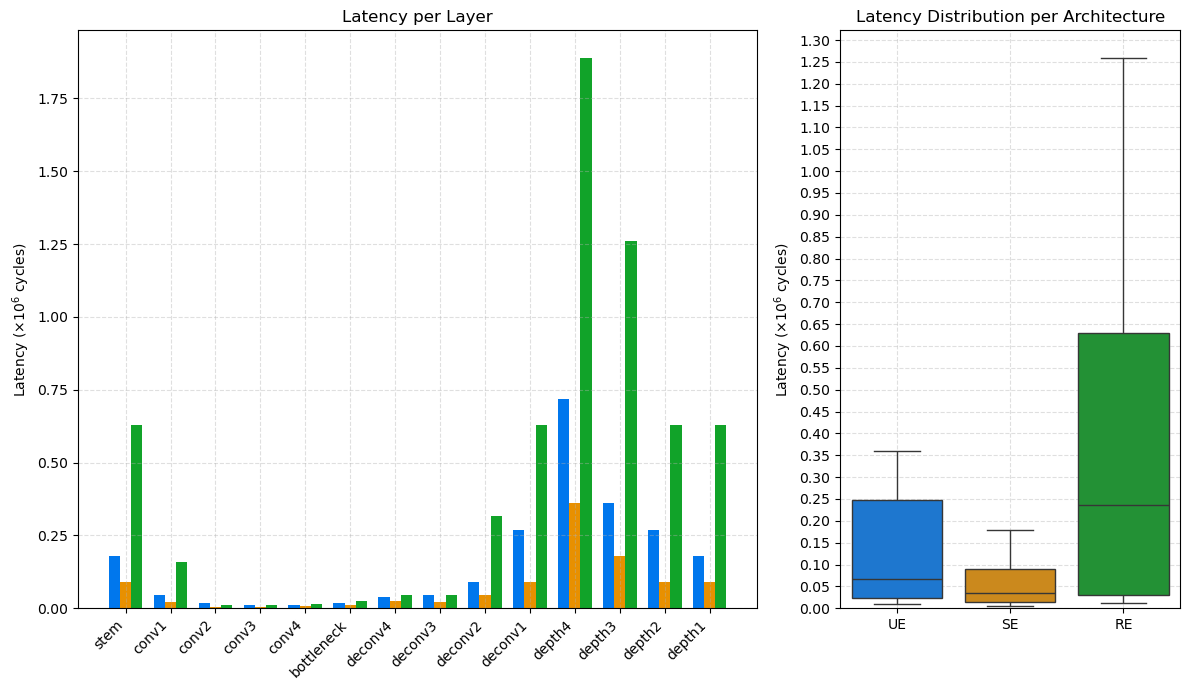

In [9]:
# Analyze latency
latency_results = analyze_original_latency(
    network_layers=network_layers,    
    filter_size=filter_size,
    compute_array_ue=ue_array,
    compute_array_se=se_array_pw,
    compute_array_re=re_array,
    dw_c_inter=dw_cols_inter,
    dw_c_inter_pred=dw_cols_inter_prediction,
    dw_c_intra=dw_cols_intra,
    verbose=False
)

In [10]:
# Visualize numerical results
pprint(latency_results)

[{'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 179920,
  'layer': 'stem'},
 {'RE_latency': 157430,
  'SE_latency': 22490,
  'UE_latency': 44980,
  'layer': 'conv1'},
 {'RE_latency': 11310,
  'SE_latency': 5655,
  'UE_latency': 16965,
  'layer': 'conv2'},
 {'RE_latency': 11616,
  'SE_latency': 5808,
  'UE_latency': 10164,
  'layer': 'conv3'},
 {'RE_latency': 13838,
  'SE_latency': 5984,
  'UE_latency': 9724,
  'layer': 'conv4'},
 {'RE_latency': 25058,
  'SE_latency': 11968,
  'UE_latency': 17952,
  'layer': 'bottleneck'},
 {'RE_latency': 46464,
  'SE_latency': 23232,
  'UE_latency': 37752,
  'layer': 'deconv4'},
 {'RE_latency': 45240,
  'SE_latency': 22620,
  'UE_latency': 45240,
  'layer': 'deconv3'},
 {'RE_latency': 314860,
  'SE_latency': 44980,
  'UE_latency': 89960,
  'layer': 'deconv2'},
 {'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 269880,
  'layer': 'deconv1'},
 {'RE_latency': 1889160,
  'SE_latency': 359840,
  'UE_latency': 719680,
  'layer': 'd

##### **1.2.1.2 Case 2**
- Input channels = Output channels.
- Resemble *bottleneck* conditions.

**UE:**
- For DW convolution: (49,128)
- For PW convolution: (128,128)
- Therefore, we use: *(49,128)*
    - DW convolution can handle 128 input channels with all the filter rows.
    - PW convolution can produce 128 output channels.

**SE:** 
- For DW convolution: (49,128)
- For PW convolution: (128,128)
    - DW convolution can handle 128 input channels with all the filter rows.
    - PW convolution can produce 128 output channels.

**RE:**
- For DW convolution: (7,128)
    - Its dataflow only considers the access to a single row with all their channels and perform an incomplete slididing window in several cycles. 
- For PW convolution: (128,128)  
- Therefore, we use: *(128,128)*
    - DW convolution can handle up to 128 input channels with a single filter row per cycle (idle PEs).
    - PW convolution can handle up to 128 input channels and produce 128 output channels.  
    
- *Inter-channel* --> small number of input/output channels
    - Choose a balance approach with 64 columns for each stage: handle 64 input channels and generate 64 output channels.
    - We use *d = 64*
    - In the case of prediction layers with only 1 output channel, we use optimize to *d = 127*  

- *Intra-channel* --> large number of input/output channels
    - Dynamic assignment of columns for both convolutions --> 2 stages.
    - During stage 1, most of the computations are focused on finishing DW convolutions
        - We use *d = 120*
    - Stage 2 automatically will take all 128 columns to complete PW convolutions. 

In [11]:
# (row, column) --> (i,j)

# UE
ue_array = (49, 128)

# SE
# (row, column) --> (i,j)
se_array_dw = (49, 128)
se_array_pw = (128, 128)

# RE
# (row, column) --> (i,j)
re_array = (128, 128)
dw_cols_inter = 64  # Number of columns for DW in RE for inter-channel
dw_cols_inter_prediction = 127  # Number of columns for DW in RE for inter-channel operation in prediction layers
dw_cols_intra = 120  # Number of columns for DW in RE for intra-channel

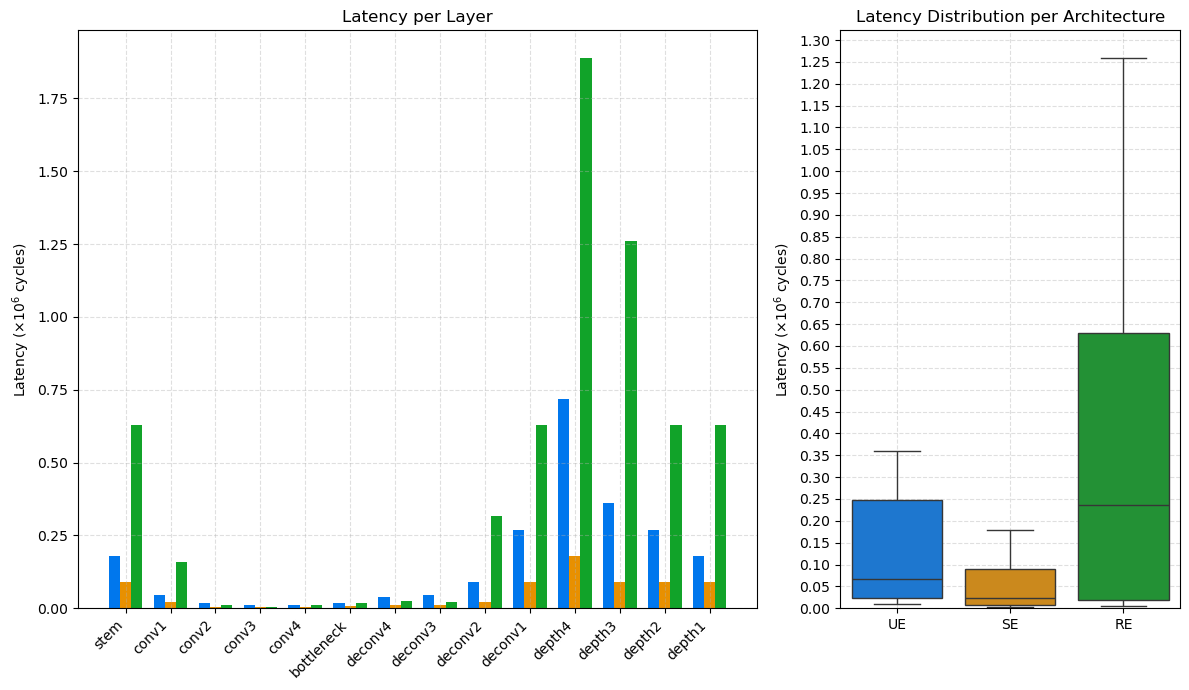

In [12]:
# Analyze latency
latency_results = analyze_original_latency(
    network_layers=network_layers,    
    filter_size=filter_size,
    compute_array_ue=ue_array,
    compute_array_se=se_array_pw,
    compute_array_re=re_array,
    dw_c_inter=dw_cols_inter,
    dw_c_inter_pred=dw_cols_inter_prediction,
    dw_c_intra=dw_cols_intra,
    verbose=False
)

In [13]:
# Visualize numerical results
pprint(latency_results)

[{'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 179920,
  'layer': 'stem'},
 {'RE_latency': 157430,
  'SE_latency': 22490,
  'UE_latency': 44980,
  'layer': 'conv1'},
 {'RE_latency': 11310,
  'SE_latency': 5655,
  'UE_latency': 16965,
  'layer': 'conv2'},
 {'RE_latency': 5808,
  'SE_latency': 2904,
  'UE_latency': 10164,
  'layer': 'conv3'},
 {'RE_latency': 10846,
  'SE_latency': 2992,
  'UE_latency': 9724,
  'layer': 'conv4'},
 {'RE_latency': 19074,
  'SE_latency': 5984,
  'UE_latency': 17952,
  'layer': 'bottleneck'},
 {'RE_latency': 23232,
  'SE_latency': 11616,
  'UE_latency': 37752,
  'layer': 'deconv4'},
 {'RE_latency': 22620,
  'SE_latency': 11310,
  'UE_latency': 45240,
  'layer': 'deconv3'},
 {'RE_latency': 314860,
  'SE_latency': 22490,
  'UE_latency': 89960,
  'layer': 'deconv2'},
 {'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 269880,
  'layer': 'deconv1'},
 {'RE_latency': 1889160,
  'SE_latency': 179920,
  'UE_latency': 719680,
  'layer': 'dep

##### **1.2.1.3 Case 3**
- Input channels > Output channels.
- Resemble *decoder* conditions.

**UE:**
- For DW convolution: (49,128)
- For PW convolution: (128,64)
- Therefore, we use: *(49,64)*
    - DW convolution can handle 128 input channels with all the filter rows.
    - PW convolution can produce 64 output channels.

**SE:** 
- For DW convolution: (49,128)
- For PW convolution: (128,64)
    - DW convolution can handle 128 input channels with all the filter rows.
    - PW convolution can produce 64 output channels.

**RE:**
- For DW convolution: (7,128)
    - Its dataflow only considers the access to a single row with all their channels and perform an incomplete slididing window in several cycles. 
- For PW convolution: (128,64)  
- Therefore, we use: *(128,128)*
    - DW convolution can handle up to 128 input channels with a single filter row per cycle (idle PEs).
    - PW convolution can handle up to 128 input channels and produce 128 output channels.  
    
- *Inter-channel* --> small number of input/output channels
    - Choose a balance approach with 64 columns for each stage: handle 64 input channels and generate 64 output channels.
    - We use *d = 64*
    - In the case of prediction layers with only 1 output channel, we use optimize to *d = 127*  

- *Intra-channel* --> large number of input/output channels
    - Dynamic assignment of columns for both convolutions --> 2 stages.
    - During stage 1, most of the computations are focused on finishing DW convolutions
        - We use *d = 120*
    - Stage 2 automatically will take all 128 columns to complete PW convolutions. 

In [14]:
# (row, column) --> (i,j)

# UE
ue_array = (49, 64)

# SE
# (row, column) --> (i,j)
se_array_dw = (49, 128)
se_array_pw = (128, 64)

# RE
# (row, column) --> (i,j)
re_array = (128, 128)
dw_cols_inter = 64  # Number of columns for DW in RE for inter-channel
dw_cols_inter_prediction = 127  # Number of columns for DW in RE for inter-channel operation in prediction layers
dw_cols_intra = 120  # Number of columns for DW in RE for intra-channel

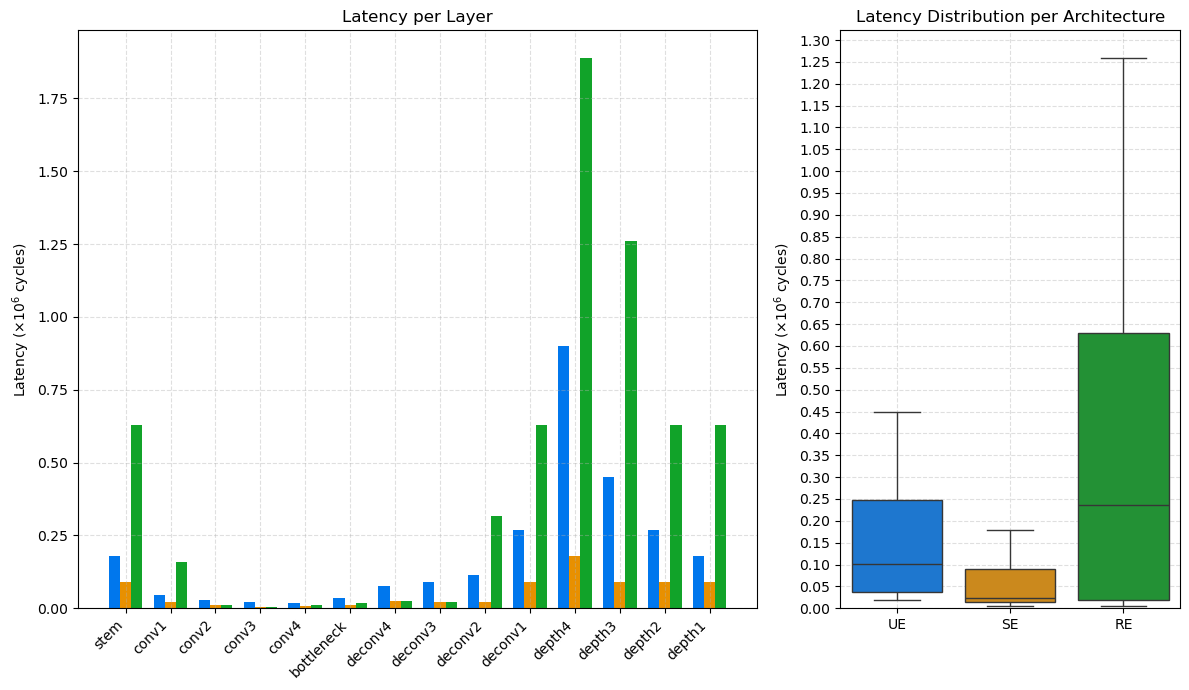

In [15]:
# Analyze latency
latency_results = analyze_original_latency(
    network_layers=network_layers,    
    filter_size=filter_size,
    compute_array_ue=ue_array,
    compute_array_se=se_array_pw,
    compute_array_re=re_array,
    dw_c_inter=dw_cols_inter,
    dw_c_inter_pred=dw_cols_inter_prediction,
    dw_c_intra=dw_cols_intra,
    verbose=False
)

In [16]:
# Visualize numerical results
pprint(latency_results)

[{'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 179920,
  'layer': 'stem'},
 {'RE_latency': 157430,
  'SE_latency': 22490,
  'UE_latency': 44980,
  'layer': 'conv1'},
 {'RE_latency': 11310,
  'SE_latency': 11310,
  'UE_latency': 28275,
  'layer': 'conv2'},
 {'RE_latency': 5808,
  'SE_latency': 5808,
  'UE_latency': 20328,
  'layer': 'conv3'},
 {'RE_latency': 10846,
  'SE_latency': 5984,
  'UE_latency': 19448,
  'layer': 'conv4'},
 {'RE_latency': 19074,
  'SE_latency': 11968,
  'UE_latency': 35904,
  'layer': 'bottleneck'},
 {'RE_latency': 23232,
  'SE_latency': 23232,
  'UE_latency': 75504,
  'layer': 'deconv4'},
 {'RE_latency': 22620,
  'SE_latency': 22620,
  'UE_latency': 90480,
  'layer': 'deconv3'},
 {'RE_latency': 314860,
  'SE_latency': 22490,
  'UE_latency': 112450,
  'layer': 'deconv2'},
 {'RE_latency': 629720,
  'SE_latency': 89960,
  'UE_latency': 269880,
  'layer': 'deconv1'},
 {'RE_latency': 1889160,
  'SE_latency': 179920,
  'UE_latency': 899600,
  'layer': 

- **SE architeture** shows a reduced and more consist latency among layers. 
- In the case of RE, we can see that its large variability is due to its dataflow, which depends on the input resolution.
    - Dataflow processes a single ifmap row.

## **2. Proposed Architecture**
- Based on the previous analysis, the best candidate to implement StereoSpike network is the **SE architecture**. 
    - We proposed a variation that eliminates the storage of intermediate data (pfmaps) to reduce on-chip traffic.
    - Also off-chip traffic is reduced by reading only the initial event frames and compute consecutive layers with the on-chip data.

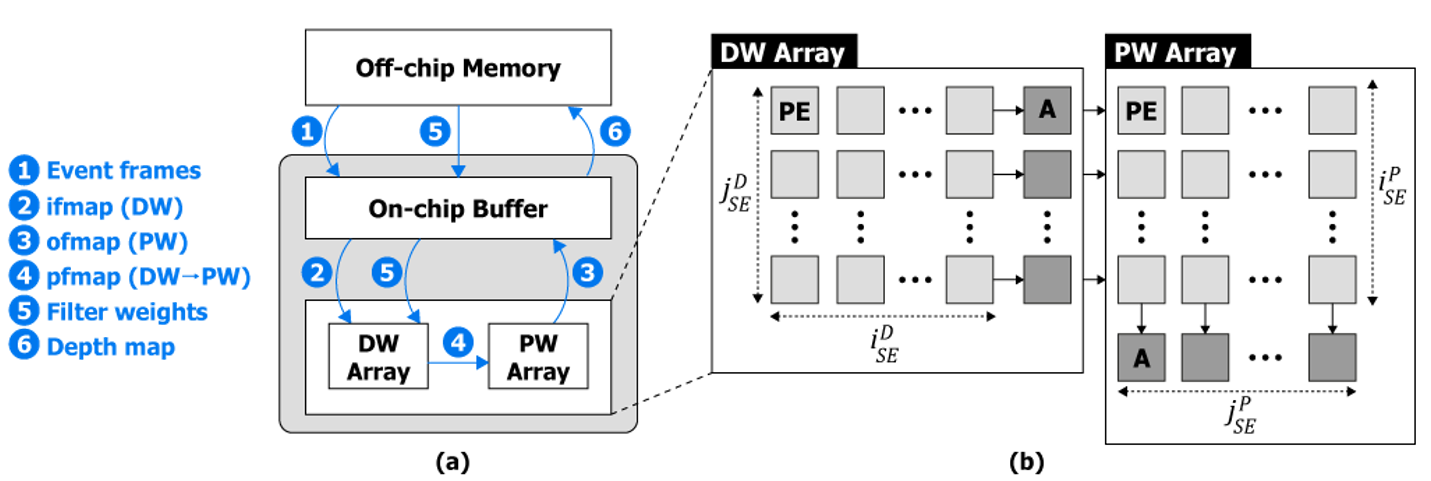

### **2.1 Memory Traffic**
- Following the previous framework, equations for the proposed architecture are presented.

The size of the individual tensors are:  
- &#9312; Event frames --> $HWC$ (binary data)
- &#9313; ifmap (DW) --> $HWC$ (binary data)
- &#9314; ofmap (PW) --> $PQM$ (binary/multibit data)
- &#9315; pfmap (DW->PW) --> $PQC$ (multibit data)
- &#9316; weights --> $RSC + MC$ (multibit data)
- &#9317; Depth map --> $PQ$ (multibit data) 

**Off-chip:**  
- &#9312; is binary.  
- &#9316; and &#9317; are multibit.
$$
    A^{off} = \underset{\text{read}}{\underbrace{1+5}} + \underset{\text{write}}{\underbrace{6}}
$$

**On-chip:**
- Following the previous ideal estimations, we also consider just 1 binary ofmap write and 1 multibit ofmap read.
    - &#9313; and &#9314; (write) are binary.  
    - &#9314; (read) and &#9316; are multibit.
$$
    A^{on} = \underset{\text{read}}{\underbrace{2+3+5}} + \underset{\text{write}}{\underbrace{3}}
$$

#### **2.1.1 Analysis**
The bitwidth of each tensor element determines the memory traffic with a fixed network.
- Assume 8-bit quantization for weights.

In [17]:
# Bitwidths for weights, pfmap, and ofmap
n_bits = (8, 16, 16)

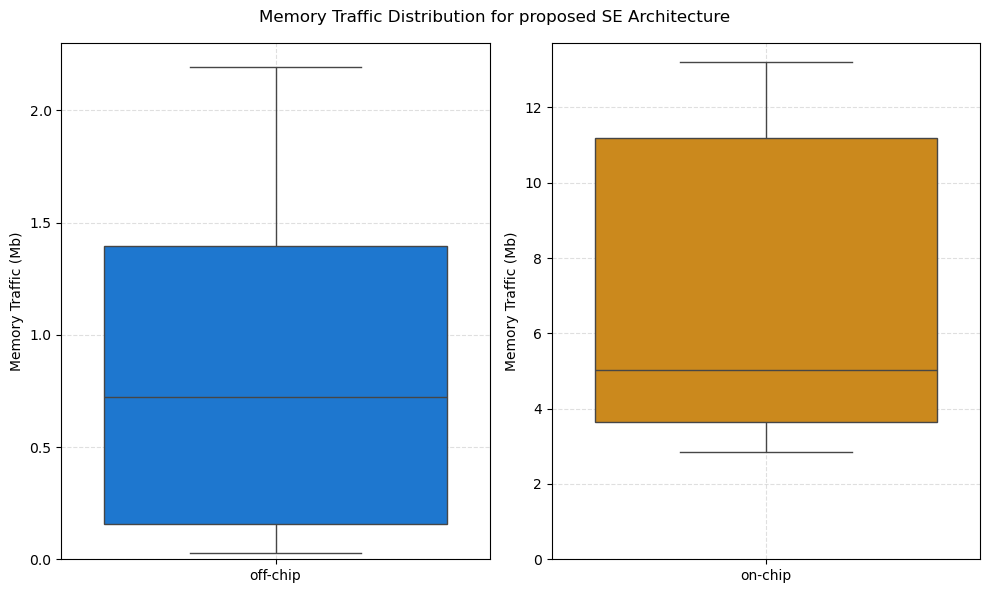

In [18]:
# Analyze memory traffic
prop_traffic_results = analyze_prop_mem_traffic(
    network_layers=network_layers,
    filter_size=filter_size,
    n_bit=n_bits
)

In [19]:
pprint(prop_traffic_results)

[{'layer': 'stem',
  'off_1': 0.343170166015625,
  'off_5': 0.002471923828125,
  'off_6': 0.0,
  'off_total': 0.34564208984375,
  'on_2': 0.343170166015625,
  'on_3': 2.745361328125,
  'on_5': 0.002471923828125,
  'on_total': 3.09100341796875},
 {'layer': 'conv1',
  'off_1': 0.0,
  'off_5': 0.027587890625,
  'off_6': 0.0,
  'off_total': 0.027587890625,
  'on_2': 2.745361328125,
  'on_3': 1.3726806640625,
  'on_5': 0.027587890625,
  'on_total': 4.1456298828125},
 {'layer': 'conv2',
  'off_1': 0.0,
  'off_5': 0.08642578125,
  'off_6': 0.0,
  'off_total': 0.08642578125,
  'on_2': 1.3726806640625,
  'on_3': 11.7352294921875,
  'on_5': 0.08642578125,
  'on_total': 13.1943359375},
 {'layer': 'conv3',
  'off_1': 0.0,
  'off_5': 0.2978515625,
  'off_6': 0.0,
  'off_total': 0.2978515625,
  'on_2': 0.6903076171875,
  'on_3': 6.0263671875,
  'on_5': 0.2978515625,
  'on_total': 7.0145263671875},
 {'layer': 'conv4',
  'off_1': 0.0,
  'off_5': 1.095703125,
  'off_6': 0.0,
  'off_total': 1.095703125,

### **2.2 Latency**
- The proposed modification of SE architecture follows the previous formulas for latency estimation.

#### **2.2.1 Analysis**
The number of rows and columns $(i,j)$ determines the latency with a fixed network.
- Due to the direct feed from DW array to PW array, the dimensions of PW array defined both arrays.
    - Consider the max. number of input/output channels as the limits for the seach: 512.

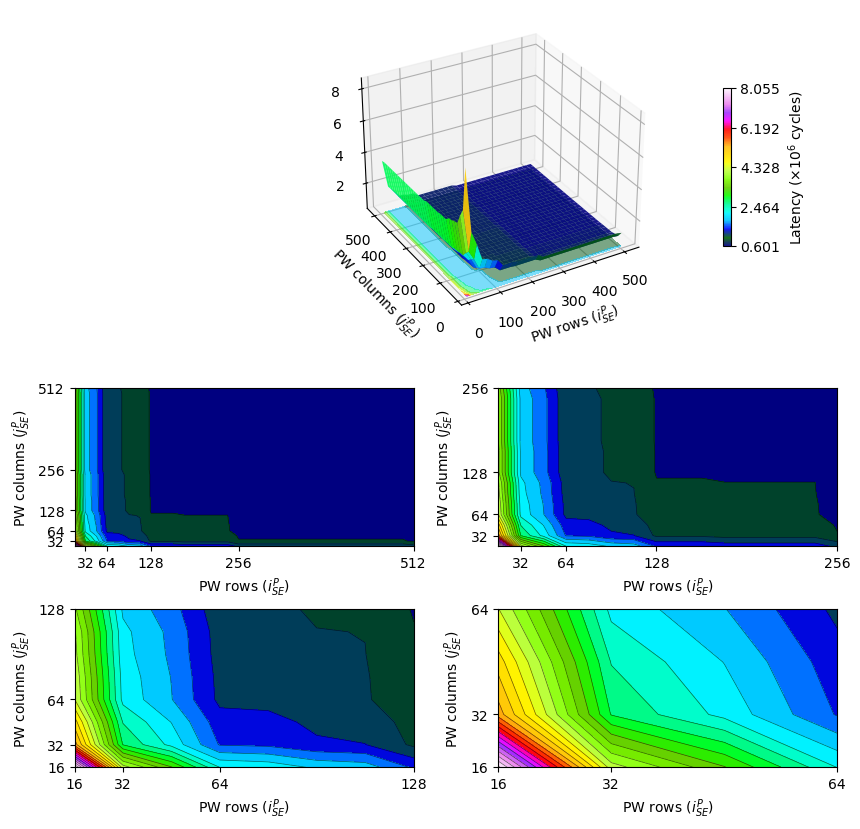

In [20]:
latency_grid_m, i_vals, j_vals = plot_total_se_latency_surface(
    network_layers=network_layers,
    se_array_pw_range_i=(16, 512),
    se_array_pw_range_j=(16, 512),
    step_i=16,
    step_j=16,
    cmap='gist_ncar'
)

- The following options have been selected for further analysis considering that larger arrays will affect hardware implementation due to area.

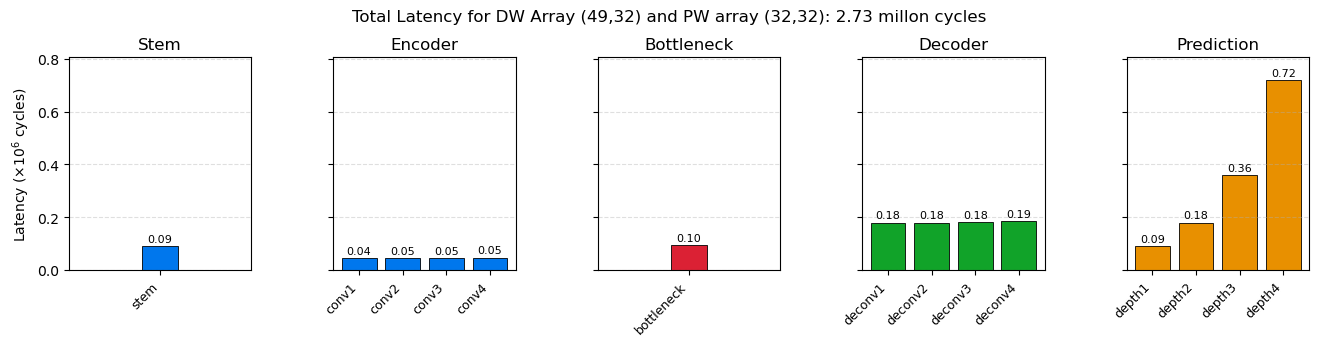

In [21]:
# (row, column) --> (i,j)
# SE
se_array_dw = (49, 32)
se_array_pw = (32, 32)

# Analyze latency
latency_results = analyze_se_latency(
    network_layers=network_layers,    
    compute_array=se_array_pw,
    latency_grid_m=latency_grid_m,
    i_vals=i_vals,
    j_vals=j_vals
)

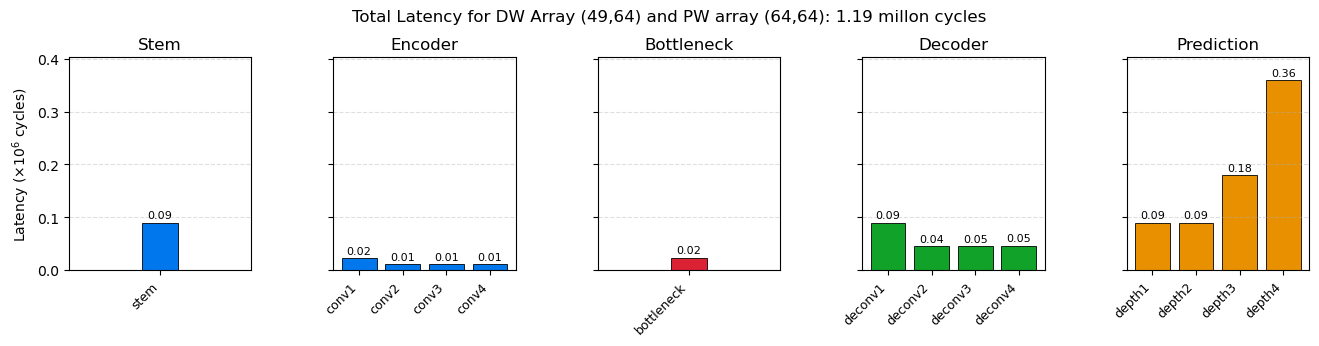

In [22]:
# (row, column) --> (i,j)
# SE
se_array_dw = (49, 64)
se_array_pw = (64, 64)

# Analyze latency
latency_results = analyze_se_latency(
    network_layers=network_layers,    
    compute_array=se_array_pw,
    latency_grid_m=latency_grid_m,
    i_vals=i_vals,
    j_vals=j_vals
)

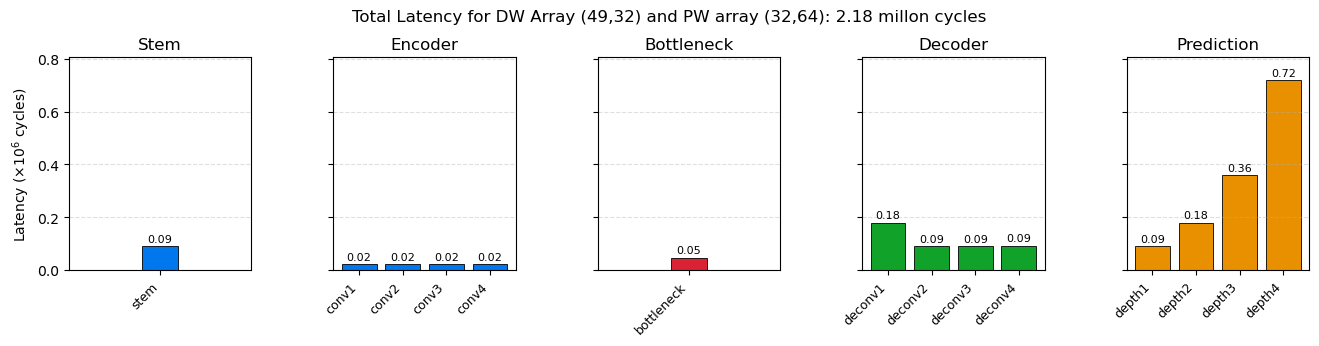

In [23]:
# (row, column) --> (i,j)
# SE
se_array_dw = (49, 32)
se_array_pw = (32, 64)

# Analyze latency
latency_results = analyze_se_latency(
    network_layers=network_layers,    
    compute_array=se_array_pw,
    latency_grid_m=latency_grid_m,
    i_vals=i_vals,
    j_vals=j_vals
)

- Initially, Two extremes where compared: small array (32,32) and big array (64,64).
- The big array reduces 2.3x the latency, but the area requirement is 4x.
- Therefore, a more balance approach was considered. A (32,64) array reduces 1.25x latency and only requires 2x the area.
    - This one is also selected to prioritize the generation of output channels.

## **3. Conclusions**
- Based on memory traffic analysis and latency, SE architecture is the most suitable to implement StereoSpike network.
- A modified SE architecture was proposed to eliminate intermediate data storage.
- The modified SE architecture follows the conventional SE latency model.
- Based on the analysis of total latency, area requirements, and prioritizing output channel generation, a balance array size was selected for implementation.

# **References**
[1] B. Li et al., “Dynamic Dataflow Scheduling and Computation Mapping Techniques for Efficient Depthwise Separable Convolution Acceleration,” IEEE Trans. Circuits Syst. I: Reg. Papers, vol. 68, no. 8, pp. 3279–3292, Aug. 2021. https://doi.org/10.1109/TCSI.2021.3078541.  
[2] V. Sze, Y.-H. Chen, T.-J. Yang, and J. S. Emer, Efficient Processing of Deep Neural Networks, 1st ed., Synthesis Lectures on Computer Architecture. Springer Cham, 2020. https://doi.org/10.1007/978-3-031-01766-7.  
[3] G. Gallego et al., “Event-Based Vision: A Survey,” IEEE Trans. Pattern Anal. Mach. Intell., vol. 44, no. 1, pp. 154–180, Jan. 2022, doi:10.1109/TPAMI.2020.3008413.